# Conversation Search Engine

The goal of this assignement is to make a semantic search engine. This tool will facilitates searches through large datasets of conversations by leveraging Machine Learning tools in order to extract the most related result to a given search query. 

### Sections
- **Importing needed modules :**
[go to section](#importing)

- **Preparing the data :**
[go to section](#preparing)

- **Visualizations :**
[go to section](#visualization)

- **Preprocessing the data :**
[go to section](#preprocessing)

- **Machine Learning Approach :**
[go to section](#machine_learning)

- **Deep Learning Approach :**
[go to section](#deep_learning)

- **Conclusion :**
[go to section](#conclusion)


<a id='importing'></a>
## Importing universally needed modules

We will import other specific ones as we go through the task.

In [109]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re

In [5]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_colwidth', 300)

<a id='preparing'></a>
## Reading and preparing the data

I've looked for a conversations dataset in order to assess my approaches and although I didn't have much time to do it (otherwise I could've found a specific one), I've found a decent one.

In [6]:
import json
with open("../input/iq2_data_release.json", 'r') as read_file:
    data = json.load(read_file)

In [7]:
df = []
for value in data.values():
    for speech in value["transcript"]:
        df = df + [paragraph for paragraph in speech["paragraphs"]]


df = pd.DataFrame(df, columns=["text"])
df.head()

,text
0,"… And now I’d like to introduce Robert Rosenkranz, who is the chairman of the Rosenkranz Foundation, and the sponsor of Intelligence Squared, who will frame tonight’s debate. Bob? This is Bob."
1,"Well thank you very much. And, uh, uh, on behalf of, uh, Dana Wolfe, our executive producer and myself, uh, I’m just, uh, thrilled to welcome you. When we scheduled this event some, uh, five months ago, we had no idea it would be so timely. Just in the past month the, uh, Mitchell Report was rel..."
2,"Thank you again, Bob. So this is the sixth debate of the second Intelligence Squared US Series. The resolution being debated tonight is formally, you know what it is, but formally it is, we should accept performance-enhancing drugs in competitive sports. Here’s a brief overview of the way the ev..."
3,"Thank you. Everyone in this room uses performance-enhancing technology and drugs. We use cars and computers to make our work more efficient. We use caffeine, alcohol, and Viagra to improve our performance. We send our children to fancy schools and Suzuki lessons to improve their cognitive skills..."
4,"…eh…Alzado is constantly rolled out as a poster child for the horrors of steroids. I ask you in the audience to quickly name, in The Rosenkranz Foundation - Intelligence Squared US Debate “Performance Enhancing Drugs in Competitive Sports” your own minds, a single elite athlete who’s had a strok..."


<a id='visualization'></a>
## Some visualization

Visualzing data is an important part to assess what we have at hand and make a sense for the next move, including the features to extract and the model to utilize. In this section I will provide some simple graphs for properties of this particular dataset. Of course, more advanced work could be done here but I have a time constraint.

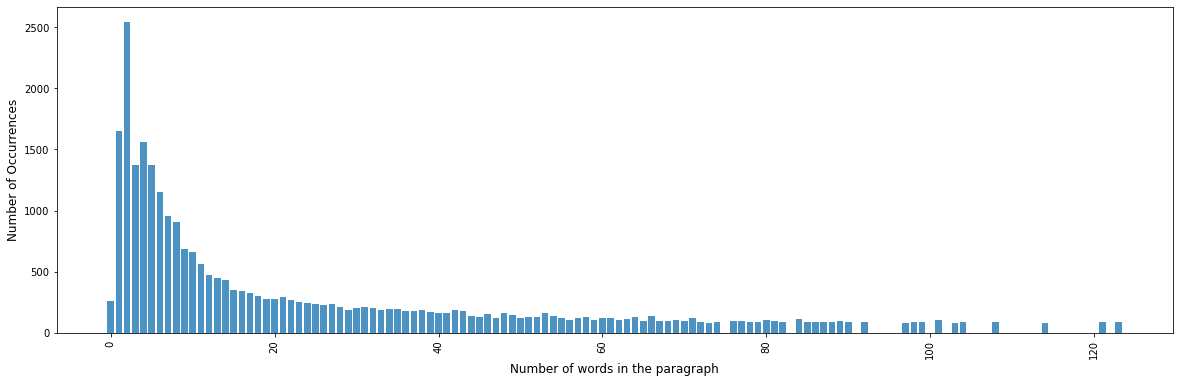

In [130]:
count_str = df["text"].apply(lambda x: len(str(x).split())).value_counts()
count_str = count_str[:100] #for better visibility

plt.figure(figsize=(20,6))
plt.bar(count_str.index, count_str.values, alpha=0.8)
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Number of words in the paragraph', fontsize=12)
plt.xticks(rotation='vertical')
plt.show()

<a id='preprocessing'></a>
## Processing the data

First of all, raw text needs to go through a few initial preprocessing steps in order to clean characters and extra spaces, correct spelling mistakes (or at least some of them) and standardize words (lemmatization), and finally put it in the proper form for the model (tokenization). 
These techniques don't have to be all used together, because it depends on the model to be used as some of them might lower performance for deep learning techniques for example. So they are to be tested.

Other techniques can be added or enhanced here (but couldn't do due to time constraints), such as advanced spelling correction, recognition of proper nouns as they have special meaning beyond the meaning of the words that compose them etc..

In [8]:
train = df.copy()

### Lower Uppercase letters

In [9]:
train["text"] = train["text"].apply(lambda x : x.lower())

### Expand contractions


This code takes care of contractions like "aren't" and the like and converts them to their expanded form in order to normalize the text and so the model doesn't interpret them as different terms.

_"contractions.json" : this file contains pairs of many common slang terms and their expanded versions._

In [10]:
import json
with open("../input/contractions.json", "r") as read_file:
    data = json.load(read_file)
    
contractions = data['contractions']
list(contractions.items())[:10]

[("aren't", 'are not'),
 ("can't", 'cannot'),
 ("couldn't", 'could not'),
 ("didn't", 'did not'),
 ("doesn't", 'does not'),
 ("don't", 'do not'),
 ("hadn't", 'had not'),
 ("hasn't", 'has not'),
 ("haven't", 'have not'),
 ("he'd", 'he would')]

In [11]:
def expand_contractions(x) :
    result = x
    for (key, val) in contractions.items():
        result = result.replace('’', '\'').replace(key, val)
        #print(key, val)
    return result

In [12]:
train['text'] = train['text'].apply(expand_contractions)
train.head()

,text
0,"… and now I would like to introduce robert rosenkranz, who is the chairman of the rosenkranz foundation, and the sponsor of intelligence squared, who will frame tonight is debate. bob? this is bob."
1,"well thank you very much. and, uh, uh, on behalf of, uh, dana wolfe, our executive producer and myself, uh, I am just, uh, thrilled to welcome you. when we scheduled this event some, uh, five months ago, we had no idea it would be so timely. just in the past month the, uh, mitchell report was re..."
2,"thank you again, bob. so this is the sixth debate of the second intelligence squared us series. the resolution being debated tonight is formally, you know what it is, but formally it is, we should accept performance-enhancing drugs in competitive sports. here is a brief overview of the way the e..."
3,"thank you. everyone in this room uses performance-enhancing technology and drugs. we use cars and computers to make our work more efficient. we use caffeine, alcohol, and viagra to improve our performance. we send our children to fancy schools and suzuki lessons to improve their cognitive skills..."
4,"…eh…alzado is constantly rolled out as a poster child for the horrors of steroids. i ask you in the audience to quickly name, in the rosenkranz foundation - intelligence squared us debate “performance enhancing drugs in competitive sports” your own minds, a single elite athlete who is had a stro..."


### Convert to lowercase and clean extra spaces and unecessary punctuation (changeable)

In [13]:
def clean(x) :
    return re.sub('[^\w\s]|\s\s+',' ', x.lower()) #.replace('\s\s+', ' ')

In [14]:
train['text'] = train['text'].apply(clean)
train.head()

,text
0,and now i would like to introduce robert rosenkranz who is the chairman of the rosenkranz foundation and the sponsor of intelligence squared who will frame tonight is debate bob this is bob
1,well thank you very much and uh uh on behalf of uh dana wolfe our executive producer and myself uh i am just uh thrilled to welcome you when we scheduled this event some uh five months ago we had no idea it would be so timely just in the past month the uh mitchell report was re...
2,thank you again bob so this is the sixth debate of the second intelligence squared us series the resolution being debated tonight is formally you know what it is but formally it is we should accept performance enhancing drugs in competitive sports here is a brief overview of the way the e...
3,thank you everyone in this room uses performance enhancing technology and drugs we use cars and computers to make our work more efficient we use caffeine alcohol and viagra to improve our performance we send our children to fancy schools and suzuki lessons to improve their cognitive skills...
4,eh alzado is constantly rolled out as a poster child for the horrors of steroids i ask you in the audience to quickly name in the rosenkranz foundation intelligence squared us debate performance enhancing drugs in competitive sports your own minds a single elite athlete who is had a stro...


### (Bonus) Removing Slang and emojis (if applicable)

I don't if this applicable but conversations may contain slang words (like omg and brb etc..) and maybe emojis so this bit of code takes care of them (I applied them to tweets before but just have to generalize them if needed)

In [ ]:
def remove_emoji(row):
    text = row['text']
    emoji_pattern = re.compile(
        "["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        "]+",
        flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

In [ ]:
train['text'] = train['text'].apply(remove_emoji)

_"slang.json" : This file contains pairs of many common slang terms and their expanded versions._

In [ ]:
import json
with open("../input/slang.json", "r") as read_file:
    slang = json.load(read_file)
    
slang_dict = slang['slang']
list(slang_dict.items())[:10]

In [ ]:
def unslang(x):
    """Converts text like "OMG" into "Oh my God" """
    text_split = x.split(' ')
    res = []
    for word in text_split :
        if word.upper() in slang_dict.keys():
            res.append(slang_dict[word.upper()].lower())
        else:
            res.append(word)
    return ' '.join(res)

In [ ]:
train['text'] = train['text'].apply(unslang)
train.head()

### Correct spelling mistakes (Optional)

Here I use pyspellchecker which sometimes doesn't give good results, as I've tried it before, but it depends on the dataset and it might prove to be good enough.

In [ ]:
!pip install pyspellchecker
from spellchecker import SpellChecker

In [ ]:
spell = SpellChecker()
def correct_misspells(text):
    corrected_text = []
    misspelled_words = spell.unknown(text.split())
    for word in text.split() :
        if word in misspelled_words :
            corrected_text.append(spell.correction(word))
        else :
            corrected_text.append(word)
    return ' '.join(corrected_text)

In [ ]:
train['text'] = train['text'].apply(correct_misspells)

 ### Stemming (didn't apply here, isn't needed and removes parts of words)

In [ ]:
from nltk.stem import SnowballStemmer

def stem(x):
    
    text = x.split()
    stemmer = SnowballStemmer('english')
    stemmed_words = [stemmer.stem(word) for word in text]
    text = " ".join(stemmed_words)
    
    return text

In [ ]:
train['text'] = train['text'].apply(stem)
train.head()

### Lemmatization

In [15]:
import nltk
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer   

def get_wordnet_pos(word):
    """Map POS tag to first character lemmatize() accepts"""
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}

    return tag_dict.get(tag, wordnet.NOUN)

lem = WordNetLemmatizer()
def lemmatize(x) :
    return ' '.join([lem.lemmatize(word, get_wordnet_pos(word)) for word in x.split(' ') if len(word)>=1])

In [16]:
train['text'] = train['text'].apply(lemmatize)
train.head()

,text
0,and now i would like to introduce robert rosenkranz who be the chairman of the rosenkranz foundation and the sponsor of intelligence square who will frame tonight be debate bob this be bob
1,well thank you very much and uh uh on behalf of uh dana wolfe our executive producer and myself uh i be just uh thrill to welcome you when we schedule this event some uh five month ago we have no idea it would be so timely just in the past month the uh mitchell report be release name some eighty...
2,thank you again bob so this be the sixth debate of the second intelligence square u series the resolution be debate tonight be formally you know what it be but formally it be we should accept performance enhance drug in competitive sport here be a brief overview of the way the even will work mem...
3,thank you everyone in this room us performance enhance technology and drug we use car and computer to make our work more efficient we use caffeine alcohol and viagra to improve our performance we send our child to fancy school and suzuki lesson to improve their cognitive skill and enhance their ...
4,eh alzado be constantly roll out a a poster child for the horror of steroid i ask you in the audience to quickly name in the rosenkranz foundation intelligence square u debate performance enhance drug in competitive sport your own mind a single elite athlete who be have a stroke or a heart attac...


### Removing Stopwords

This removes common words that don't carry significant meaning like "the", "and", etc...

In [17]:
from nltk.corpus import stopwords

def remove_stopwords(x) :
    # noticed some extra words not in stopwords like "uh" and "ah" so decided to remove them for now
    return ' '.join([word for word in x.split() if word not in (stopwords.words('english') + ["uh", "eh", "ah"])])

In [18]:
train['text'] = train['text'].apply(remove_stopwords)
train.head()

,text
0,would like introduce robert rosenkranz chairman rosenkranz foundation sponsor intelligence square frame tonight debate bob bob
1,well thank much behalf dana wolfe executive producer thrill welcome schedule event five month ago idea would timely past month mitchell report release name eighty eight major league baseball player allege use steroid drug roger clemens denial heard 60 minute front page news sunday new york time ...
2,thank bob sixth debate second intelligence square u series resolution debate tonight formally know formally accept performance enhance drug competitive sport brief overview way even work member team alternate present side argument presentation limited seven minute opening argument complete open ...
3,thank everyone room us performance enhance technology drug use car computer make work efficient use caffeine alcohol viagra improve performance send child fancy school suzuki lesson improve cognitive skill enhance musical ability every athlete record history use performance enhance drug babyloni...
4,alzado constantly roll poster child horror steroid ask audience quickly name rosenkranz foundation intelligence square u debate performance enhance drug competitive sport mind single elite athlete stroke heart attack play sport hard come one anabolic steroid undesirable side effect acne baldness...


### Tokenize

In [26]:
from nltk.tokenize import word_tokenize

def get_tokens(x):
    return word_tokenize(x)

In [27]:
train['tokenized'] = train['text'].apply(get_tokens)
train['tokenized'].head()

0                                                                                                                                                                [would, like, introduce, robert, rosenkranz, chairman, rosenkranz, foundation, sponsor, intelligence, square, frame, tonight, debate, bob, bob]
1    [well, thank, much, behalf, dana, wolfe, executive, producer, thrill, welcome, schedule, event, five, month, ago, idea, would, timely, past, month, mitchell, report, release, name, eighty, eight, major, league, baseball, player, allege, use, steroid, drug, roger, clemens, denial, heard, 60, minu...
2    [thank, bob, sixth, debate, second, intelligence, square, u, series, resolution, debate, tonight, formally, know, formally, accept, performance, enhance, drug, competitive, sport, brief, overview, way, even, work, member, team, alternate, present, side, argument, presentation, limited, seven, mi...
3    [thank, everyone, room, us, performance, enhance, technology, drug, use, car, co

### Aggregating the functions

In [38]:
def preprocess(x, correct_mistakes=False, apply_stemming=False, remove_extra_words=True, tokenize=False, apply_unslang=False) :
    
    x = clean(x.lower())
    x = expand_contractions(x)
    if apply_unslang:
        x = remove_emoji(x)
        x = unslang(x)
    if correct_mistakes :
        x = correct_misspells(x)
    if apply_stemming :
        x = stem(x)
    x = lemmatize(x)
    if remove_extra_words:
        x = remove_stopwords(x)
    if tokenize :
        x = get_tokens(x)
    
    return x

## Additional Visualization

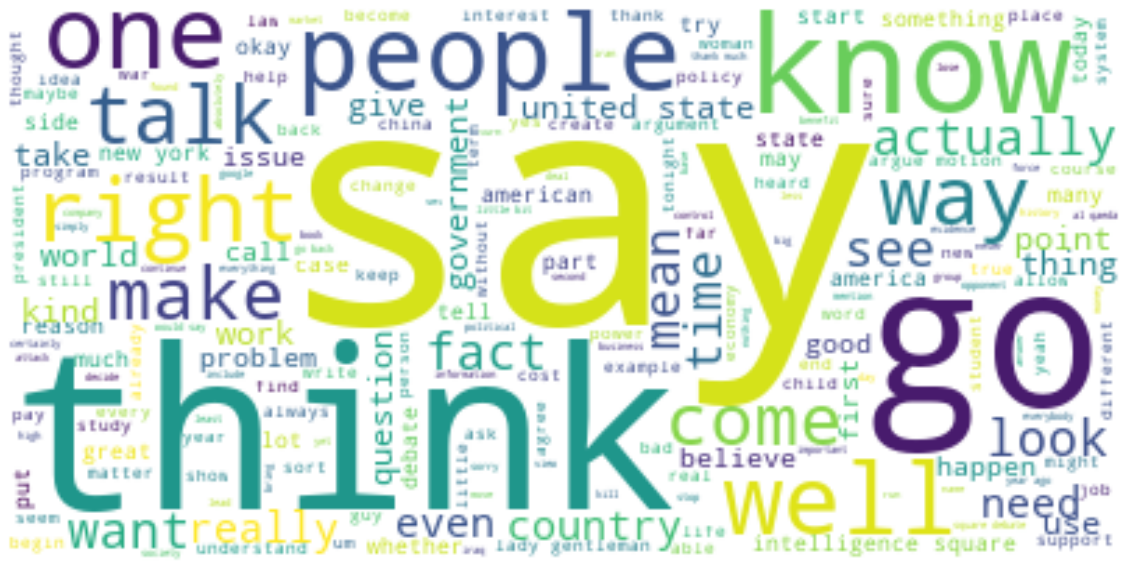

In [22]:
from wordcloud import WordCloud

wordcloud = WordCloud(background_color="white").generate(' '.join([' '.join(x) for x in train['tokenized']]))

plt.figure(figsize = (20,20))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

<a id='machine_learning'></a>
## Machine Learning Approach

The first approach to try is to apply Machine Learning techniques in order to obtain a benchmark that we can build upon later when using Deep Learning (NLP) techniques.

Basically what I did in this section is use a tfidf vectorization of each paragraph and then apply cosine similarity which will give us the most relating one to the query (hopefully).
<font color='blue'>
- Other techniques can be used to obtain better results (but wasn't able to try due to time contraints), including word2vec embeddings (instead of tfidf+ngrams), LSA to reduce dimentionality and get more representative vectors etc..
- Another goal to implement is an informative metric that will make the assessment of the performance of the model more rigorous. This might require a reformulation of the problem at hand (for example, we can organize them in query-answer pairs or annotate them manually etc..)
- In order to highlight the relevant sentence in the selected paragraphs, I think I will try to search by sentence then aggregate the result on the paragraph level, and then highlight the most similar sentence in the paragraph. This is yet to be implemented however.<font>

- **Tfidf vectorazation**

In [99]:
from sklearn.feature_extraction.text import TfidfVectorizer

def tfidf(train, label) :
    
    tf_vect = TfidfVectorizer()
    train_tdtm = tf_vect.fit_transform(train[label])
    
    # we'll need tf_vect later for transforming the search query
    return tf_vect, train_tdtm

In [30]:
tf_vect, train_tdtm = tfidf(train, "text")

<34384x22211 sparse matrix of type '<class 'numpy.float64'>'
	with 712544 stored elements in Compressed Sparse Row format>

- **Cosine Similarity**

In [31]:
from sklearn.metrics.pairwise import cosine_similarity

def cos_similarity(search_query_weights, tfidf_weights_matrix):

    cosine_distance = cosine_similarity(search_query_weights, tfidf_weights_matrix)
    similarity_list = cosine_distance[0]

    return similarity_list

- **Testing a search query**

In [63]:
search_query = "children in schools at risk of drugs"
preprocessed_query = preprocess(search_query)
print("preprocessed_query: ", preprocessed_query)
search_query_weights = tf_vect.transform([preprocessed_query])

similarity_list = cos_similarity(search_query_weights, train_tdtm)
sorted(similarity_list, reverse=True)[:10]

preprocessed_query:  child school risk drug


[0.49930084065116004,
 0.4628837691643294,
 0.43969768512168184,
 0.4270430856206747,
 0.421468000426015,
 0.41819370757079855,
 0.39200343781249375,
 0.38478154945005705,
 0.37744517301327996,
 0.37144805750748]

In [50]:
def most_similar(similarity_list, similars=1):

    similars= []

    while similars > 0:
        tmp_index = np.argmax(similarity_list)
        most_similar.append(tmp_index)
        similarity_list[tmp_index] = 0
        min_talks -= 1

    return most_similar

We can see that it gives good results, since the result text relates to the queries.

In [58]:
most_similar_items = most_similar(similarity_list, similars=5)
df.iloc[most_similar_items]

,text
32900,"Thank you. I do want to point out in all fairness that being among the foremost libertarians in America means that myself and my coauthor, you know, that's basically it. you know, you've heard from a self described soldier in the drug war. You've heard from a general, a commander, former Drug En..."
26056,"What is the urgency of people to have their DNA in their child? In fact, most of the things that our children get do not get from our DNA, they get from all the enhancement that we give them, so there's this obsession that ""My child has to have my DNA."" She did have some other choices. The risks..."
26218,"--to the point that you made, Sheldon, which is that the children are going to be born and society is not going to take care of them. Every year 4 percent of children born from natural reproduction have birth defects. Some children are abandoned by their parents. And an ethical society takes car..."
24844,No union at the school.
21257,"It was a nice spring day. What happened? With the union's help, she was put back into school in an elementary school this time. Once again, a union rep in his own words, “I've gone in and defended teachers who shouldn't even be pumping gas.” Not my quote. This is a union rep. That's the mentalit..."


In order to capture semantic relationships between words in the machine learning approach, we use ngrams while varying the n value to obtain the best result possible (low n may not capture much, high n might introduce noise). This method works well with removing stopwords.

- This section to be continued (time constraints, custom tfidf has to be implemented here)

In [84]:
def get_ngrams(text, n):
    return [tuple(text[i:i+n]) for i in range(len(text)-n+1)]

In [85]:
train['ngrams'] = train["tokenized"].apply(lambda x: get_ngrams(x, 2))
train.head()

,text,tokenized,ngrams
0,would like introduce robert rosenkranz chairman rosenkranz foundation sponsor intelligence square frame tonight debate bob bob,"[would, like, introduce, robert, rosenkranz, chairman, rosenkranz, foundation, sponsor, intelligence, square, frame, tonight, debate, bob, bob]","[(would, like), (like, introduce), (introduce, robert), (robert, rosenkranz), (rosenkranz, chairman), (chairman, rosenkranz), (rosenkranz, foundation), (foundation, sponsor), (sponsor, intelligence), (intelligence, square), (square, frame), (frame, tonight), (tonight, debate), (debate, bob), (bo..."
1,well thank much behalf dana wolfe executive producer thrill welcome schedule event five month ago idea would timely past month mitchell report release name eighty eight major league baseball player allege use steroid drug roger clemens denial heard 60 minute front page news sunday new york time ...,"[well, thank, much, behalf, dana, wolfe, executive, producer, thrill, welcome, schedule, event, five, month, ago, idea, would, timely, past, month, mitchell, report, release, name, eighty, eight, major, league, baseball, player, allege, use, steroid, drug, roger, clemens, denial, heard, 60, minu...","[(well, thank), (thank, much), (much, behalf), (behalf, dana), (dana, wolfe), (wolfe, executive), (executive, producer), (producer, thrill), (thrill, welcome), (welcome, schedule), (schedule, event), (event, five), (five, month), (month, ago), (ago, idea), (idea, would), (would, timely), (timely..."
2,thank bob sixth debate second intelligence square u series resolution debate tonight formally know formally accept performance enhance drug competitive sport brief overview way even work member team alternate present side argument presentation limited seven minute opening argument complete open ...,"[thank, bob, sixth, debate, second, intelligence, square, u, series, resolution, debate, tonight, formally, know, formally, accept, performance, enhance, drug, competitive, sport, brief, overview, way, even, work, member, team, alternate, present, side, argument, presentation, limited, seven, mi...","[(thank, bob), (bob, sixth), (sixth, debate), (debate, second), (second, intelligence), (intelligence, square), (square, u), (u, series), (series, resolution), (resolution, debate), (debate, tonight), (tonight, formally), (formally, know), (know, formally), (formally, accept), (accept, performan..."
3,thank everyone room us performance enhance technology drug use car computer make work efficient use caffeine alcohol viagra improve performance send child fancy school suzuki lesson improve cognitive skill enhance musical ability every athlete record history use performance enhance drug babyloni...,"[thank, everyone, room, us, performance, enhance, technology, drug, use, car, computer, make, work, efficient, use, caffeine, alcohol, viagra, improve, performance, send, child, fancy, school, suzuki, lesson, improve, cognitive, skill, enhance, musical, ability, every, athlete, record, history, ...","[(thank, everyone), (everyone, room), (room, us), (us, performance), (performance, enhance), (enhance, technology), (technology, drug), (drug, use), (use, car), (car, computer), (computer, make), (make, work), (work, efficient), (efficient, use), (use, caffeine), (caffeine, alcohol), (alcohol, v..."
4,alzado constantly roll poster child horror steroid ask audience quickly name rosenkranz foundation intelligence square u debate performance enhance drug competitive sport mind single elite athlete stroke heart attack play sport hard come one anabolic steroid undesirable side effect acne baldness...,"[alzado, constantly, roll, poster, child, horror, steroid, ask, audience, quickly, name, rosenkranz, foundation, intelligence, square, u, debate, performance, enhance, drug, competitive, sport, mind, single, elite, athlete, stroke, heart, attack, play, sport, hard, come, one, anabolic, steroid, ...","[(alzado, constantly), (constantly, roll), (roll, poster), (poster, child), (

<a id='deep_learning'></a>
## Deep Learning Approach

The second approach is to leverage Deep Learning techniques in order to solve this problem. Deep Learning models has been state-of-the-art when it comes to NLP tasks, especially in recent years. The rise of general-purpose, pretrained model like Google's BERT and ULMFIT etc... made leveraging them in specific tasks rather easier and more rewarding by yielding outstanding results. This is done by fine-tuning them to the task at hand, which is what I'm about to do (or start doing, as much as time allows)

For the time being, I've using BERT embeddings along with cosine similarity in order to get the best matches from the data. We'll be using it on the sentence level this time.

- **Splitting the paragraphs into sentences and preprocessing them**

In [137]:
sentences = []
paragraphs = []

for index, row in df.iterrows() :
    sentences = sentences + row["text"].split('. ')
    paragraphs = paragraphs + [index] * len(row["text"].split('. '))
    
sentences_df = pd.DataFrame(sentences, columns=["original"])
sentences_df["paragraph"] = paragraphs
sentences_df.head()

,sentence,paragraph
0,"… And now I’d like to introduce Robert Rosenkranz, who is the chairman of the Rosenkranz Foundation, and the sponsor of Intelligence Squared, who will frame tonight’s debate",0
1,Bob? This is Bob.,0
2,Well thank you very much,1
3,"And, uh, uh, on behalf of, uh, Dana Wolfe, our executive producer and myself, uh, I’m just, uh, thrilled to welcome you",1
4,"When we scheduled this event some, uh, five months ago, we had no idea it would be so timely",1


In [146]:
sentences_df["sentence"] = sentences_df["sentence"].apply(preprocess)
sentences_df.head()

,sentence,paragraph,original
0,like introduce robert rosenkranz chairman rosenkranz foundation sponsor intelligence square frame tonight debate,0,"… And now I’d like to introduce Robert Rosenkranz, who is the chairman of the Rosenkranz Foundation, and the sponsor of Intelligence Squared, who will frame tonight’s debate"
1,bob bob,0,Bob? This is Bob.
2,well thank much,1,Well thank you very much
3,behalf dana wolfe executive producer thrill welcome,1,"And, uh, uh, on behalf of, uh, Dana Wolfe, our executive producer and myself, uh, I’m just, uh, thrilled to welcome you"
4,schedule event five month ago idea would timely,1,"When we scheduled this event some, uh, five months ago, we had no idea it would be so timely"


- **Install the transformer and encoding the sentences and queries to obtain embedding to use in cosine similarity**

In [131]:
!pip install -U sentence-transformers

     |████████████████████████████████| 55 kB 1.3 MB/s eta 0:00:011
  Created wheel for sentence-transformers: filename=sentence_transformers-0.2.6.1-py3-none-any.whl size=74030 sha256=bb40fe1db16af3e2f508dd0ca665e03ccde81ae97ccbebb6dec11a6a70aff141
  Stored in directory: /root/.cache/pip/wheels/71/eb/84/05830bceaeef549ceb0257c6797254173e197e971b3f911ee4
Successfully built sentence-transformers


In [140]:
from sentence_transformers import SentenceTransformer
model = SentenceTransformer('bert-base-nli-mean-tokens')

wandb: WARNING W&B installed but not logged in.  Run `wandb login` or set the WANDB_API_KEY env variable.
100%|██████████| 405M/405M [00:28<00:00, 14.1MB/s] 


In [141]:
embeddings = model.encode(sentences_df['sentence'])

Batches: 100%|██████████| 14904/14904 [1:02:10<00:00,  3.99it/s]


- **Testing on some queries**

In [153]:
queries = ['children in schools at risk of drugs', 
           'politics and society',
           'how science is changing the world',
           'health care and weight on citizens',
           'prevalence of gun use in the united states',
           'sexual assaults victims']

query_embeddings = model.encode(queries)

Batches: 100%|██████████| 1/1 [00:00<00:00,  5.17it/s]


In [154]:
#number of closest matches to show
closest_n = 5 

from scipy.spatial.distance import cdist

for query, query_embedding in zip(queries, query_embeddings):
    
    distances = cdist([query_embedding], embeddings, "cosine")[0]

    results = zip(range(len(distances)), distances)
    results = sorted(results, key=lambda x: x[1])

    print("\n\n======================\n\n")
    print("Query:", query)
    print("\nTop 5 most similar sentences in corpus:")

    for idx, distance in results[0:closest_n]:
        print(sentences_df['original'][idx].strip(), " from paragraph ", sentences_df['paragraph'][idx], "\n(Score: %.4f)" % (1-distance),"\n")





Query: children in schools at risk of drugs

Top 5 most similar sentences in corpus:
But I do think it's particularly dangerous for young children whose-- we know their brains are in the process of being formed.  from paragraph  1593 
(Score: 0.6827) 

When kids abuse these drugs, and athletes abuse these drugs, I don’t think there’s any question that we know, uh, that there are side effects  from paragraph  28 
(Score: 0.6761) 

When kids abuse these drugs, and athletes abuse these drugs, I don’t think there’s any question that we know, uh, that there are side effects  from paragraph  25 
(Score: 0.6761) 

Their children get lower levels of schooling going forward  from paragraph  20606 
(Score: 0.6558) 

Bad test scores have consequences for kids  from paragraph  12489 
(Score: 0.6548) 





Query: politics and society

Top 5 most similar sentences in corpus:
Why? Politics  from paragraph  5573 
(Score: 0.8709) 

And because the politics--  from paragraph  12043 
(Score: 0.8709) 

<a id='conclusion'></a>
## Conslusion

There's no doubt that there's a lot of room for improvement, as there are many other techniques to try that might improve upon this humble effort. However, I've really enjoyed working through the problem and utilizing different techniques to try to solve it. I can't wait to tackle my next problem !